### Consumer complaints dataset . It can be downloaded from https://catalog.data.gov/dataset/consumer-complaint-database

In [2]:
import pandas as pd
consumer_complaints_df = pd.read_csv("Consumer_Complaints.csv")
consumer_complaints_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


### Printing list of unique classes

In [7]:
consumer_complaints_df['Product'].unique()

array(['Mortgage', 'Credit reporting', 'Consumer Loan', 'Credit card',
       'Debt collection', 'Student loan', 'Bank account or service',
       'Other financial service', 'Prepaid card', 'Money transfers',
       'Checking or savings account',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Payday loan', 'Money transfer, virtual currency, or money service',
       'Credit card or prepaid card', 'Vehicle loan or lease',
       'Payday loan, title loan, or personal loan', 'Virtual currency'], dtype=object)

### Removing rows with null value for 'Consumer complaint narrative'

In [17]:
consumer_complaints_filtered_df = consumer_complaints_df[pd.notnull(consumer_complaints_df['Consumer complaint narrative'])]
consumer_complaints_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299516 entries, 1 to 1072068
Data columns (total 18 columns):
Date received                   299516 non-null object
Product                         299516 non-null object
Sub-product                     247333 non-null object
Issue                           299516 non-null object
Sub-issue                       197380 non-null object
Consumer complaint narrative    299516 non-null object
Company public response         145114 non-null object
Company                         299516 non-null object
State                           298406 non-null object
ZIP code                        296979 non-null object
Tags                            51351 non-null object
Consumer consent provided?      299516 non-null object
Submitted via                   299516 non-null object
Date sent to company            299516 non-null object
Company response to consumer    299514 non-null object
Timely response?                299516 non-null object
Consumer 

### Visualizing distribution of classes

<Figure size 720x432 with 0 Axes>

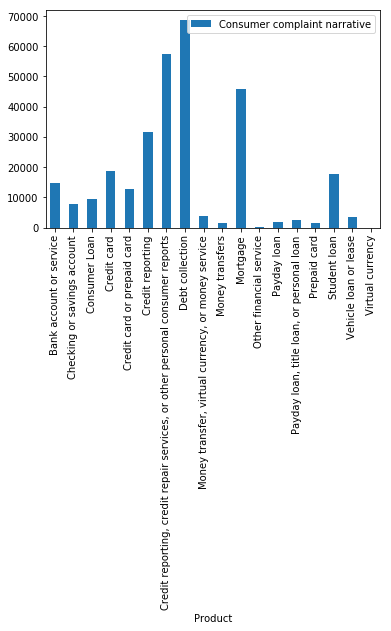

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
df = consumer_complaints_filtered_df[['Product','Consumer complaint narrative']]
df.groupby('Product').count().plot.bar(ylim=0)
plt.show()

### Preprocessing data

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

labels = df['Product']
text = df['Consumer complaint narrative']

X_train, X_test, y_train, y_test = train_test_split(text, labels, random_state=0, test_size=0.3)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_transformed = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_transformed = tf_transformer.transform(X_test_counts)

labels = LabelEncoder()
y_train_labels_fit = labels.fit(y_train)
y_train_lables_trf = labels.transform(y_train)

print(labels.classes_)

['Bank account or service' 'Checking or savings account' 'Consumer Loan'
 'Credit card' 'Credit card or prepaid card' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Money transfer, virtual currency, or money service'
 'Money transfers' 'Mortgage' 'Other financial service' 'Payday loan'
 'Payday loan, title loan, or personal loan' 'Prepaid card' 'Student loan'
 'Vehicle loan or lease' 'Virtual currency']


### Training a LinearSVC classifier and using CalibratedClassifierCV to get probabilities for each predicted class

In [30]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

linear_svc = LinearSVC()
clf = linear_svc.fit(X_train_transformed,y_train_lables_trf)

calibrated_svc = CalibratedClassifierCV(base_estimator=linear_svc,
                                        cv="prefit")

calibrated_svc.fit(X_train_transformed,y_train_lables_trf)
predicted = calibrated_svc.predict(X_test_transformed)
    
to_predict = ["I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements"]
p_count = count_vect.transform(to_predict)
p_tfidf = tf_transformer.transform(p_count)
print('Average accuracy on test set={}'.format(np.mean(predicted == labels.transform(y_test))))
print('Predicted probabilities of demo input string are')
print(calibrated_svc.predict_proba(p_tfidf))

Average accuracy on test set=0.73637527127
Predicted probabilities of demo input string are
[[  4.66096051e-04   7.61305759e-06   2.42386129e-03   8.39870195e-04
    9.63384564e-04   7.67200317e-01   2.07382738e-01   1.73294053e-02
    3.91417748e-07   3.76878086e-06   2.40907318e-03   3.80234243e-10
    1.16823419e-05   1.43313864e-05   6.93519524e-06   8.95787556e-04
    3.78217257e-05   6.92201968e-06]]


### Printing predicted probability of demo input

In [35]:
pd.DataFrame(calibrated_svc.predict_proba(p_tfidf)*100, columns=labels.classes_)

,Bank account or service,Checking or savings account,Consumer Loan,Credit card,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Money transfers,Mortgage,Other financial service,Payday loan,"Payday loan, title loan, or personal loan",Prepaid card,Student loan,Vehicle loan or lease,Virtual currency
0,0.04661,0.000761,0.242386,0.083987,0.096338,76.720032,20.738274,1.732941,0.000039,0.000377,0.240907,3.802342e-08,0.001168,0.001433,0.000694,0.089579,0.003782,0.000692
